### Importing the libararies

In [1]:
# For data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import missingno as msno
import miceforest as mf

# For data cleaning and procesing
import string
import nltk

nltk.download("stopwords")
nltk.download("wordnet")
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# For machnie learning model training
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
)
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.feature_selection import RFE
import shap
import warnings
import joblib
from sklearn.metrics import f1_score, classification_report
warnings.simplefilter(action="ignore", category=FutureWarning)

print("Everything imported successfully✅")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pheonix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pheonix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Everything imported successfully✅


/home/pheonix/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reading the data from csv file
df = pd.read_csv("../Dataset/Fake_job_data.csv")

### Introductory EDA

1. Does fraud job posting have company logo ?
2. Is there some specific location where fraud job postings are maximum ? 
3. What benifits does fraud companies offer ?
4. What is the salary range of fraud job posting ?
5. Most Fraud job posting belong to which specific industry and department ?
6. How much experience does fraud job posting demands ?
7. Fraud job posting offer which employment type

In [3]:
# Checking the shape of dataset
print("Shape of dataframe :", df.shape)

Shape of dataframe : (17880, 18)


In [4]:
# CHecking any some random rows from the dataset
df.sample(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
2377,2378,Social Media Intern,"US, NY, New York",NaN,NaN,NaN,"About Us:We are Ridogulous Labs, a hardware/so...","About You:You eat, sleep and breathe social me...",Terms and Compensation:This is an immediate ne...,0,0,0,NaN,NaN,NaN,NaN,NaN,0
8846,8847,Graduates: English Teacher Abroad (Conversatio...,"US, NH, Plymouth",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it :-)Love travel...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,Education,0
3145,3146,Front End Developer / User Interface Engineer ...,"US, CA, Los Angeles",NaN,NaN,NaN,Frontend development has changed a lot in the ...,4+ years of industry experience.Prior experien...,NaN,0,0,1,NaN,NaN,NaN,NaN,NaN,0


- From the very first look at the dataset, I feel that job_id will not make any sense to detect whether a job posting is genuine or fraud, so for that we will simply remove this column from the dataframe.
- The target variable only have 2 labels so this is binary classification problem

In [5]:
# Dropping unnecessary column from dataframe
df.drop(["job_id"], axis=1, inplace=True)

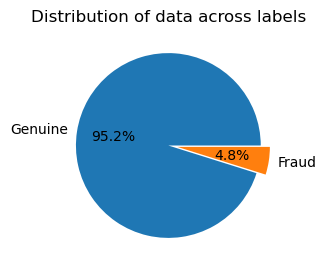

In [6]:
# Let's check the distribution of data across labels 0 -> Genuine and 1 -> Fraud
fig, ax = plt.subplots(figsize=(3, 3))

ex = [0.0, 0.1]
plt.pie(
    df["fraudulent"].value_counts(),
    labels=["Genuine", "Fraud"],
    autopct="%1.1f%%",
    explode=ex,
)
plt.title("Distribution of data across labels")
plt.show()

In [7]:
fake_jobs = df[df['fraudulent'] == 1]
genuine_jobs = df[df['fraudulent'] == 0].sample(fake_jobs.shape[0])

fake_jobs.reset_index(drop=True,inplace=True)
genuine_jobs.reset_index(drop=True,inplace=True)

In [8]:
# Combining the dataframes
df = pd.concat([fake_jobs,genuine_jobs],axis=0)

# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)

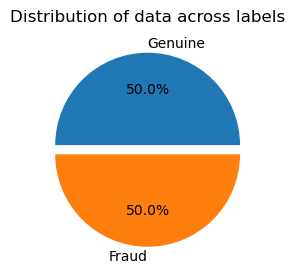

In [9]:
# Let's check the distribution of data across labels 0 -> Genuine and 1 -> Fraud
fig, ax = plt.subplots(figsize=(3, 3))

ex = [0.0, 0.1]
plt.pie(
    df["fraudulent"].value_counts(),
    labels=["Genuine", "Fraud"],
    autopct="%1.1f%%",
    explode=ex,
)
plt.title("Distribution of data across labels")
plt.show()

In [10]:
# Let's get some basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1732 non-null   object
 1   location             1696 non-null   object
 2   department           629 non-null    object
 3   salary_range         363 non-null    object
 4   company_profile      1004 non-null   object
 5   description          1731 non-null   object
 6   requirements         1445 non-null   object
 7   benefits             1023 non-null   object
 8   telecommuting        1732 non-null   int64 
 9   has_company_logo     1732 non-null   int64 
 10  has_questions        1732 non-null   int64 
 11  employment_type      1335 non-null   object
 12  required_experience  953 non-null    object
 13  required_education   897 non-null    object
 14  industry             1213 non-null   object
 15  function             1066 non-null   object
 16  fraudu

- There are some missing values in the dataset
- For storing the numerical data instead of using the float64 or int64 we can use the int32 or float32 datatype to reduce the memory usage.

In [11]:
# Changing the datatype to reduce the memory usage
int_cols = df.select_dtypes(include=np.int64)
float_cols = df.select_dtypes(include=np.float64)

df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

- Before memory usage : 2.3 mb
- After memory usage : 2.0 mb

In [12]:
# Let's check if there are any duplicate values
duplicate_values = df.duplicated().sum()
if duplicate_values != 0:
    print("Total duplicate values : " + str(duplicate_values))
    df.drop_duplicates(inplace=True)
    print("Duplicate values removed")

Total duplicate values : 11
Duplicate values removed


In [13]:
# Let's check if there are any missing values
df.isnull().mean() * 100

title                   0.000000
location                2.091807
department             63.683905
salary_range           79.023823
company_profile        41.894248
description             0.058106
requirements           16.502034
benefits               40.906450
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        22.777455
required_experience    44.799535
required_education     48.111563
industry               29.866357
function               38.291691
fraudulent              0.000000
dtype: float64

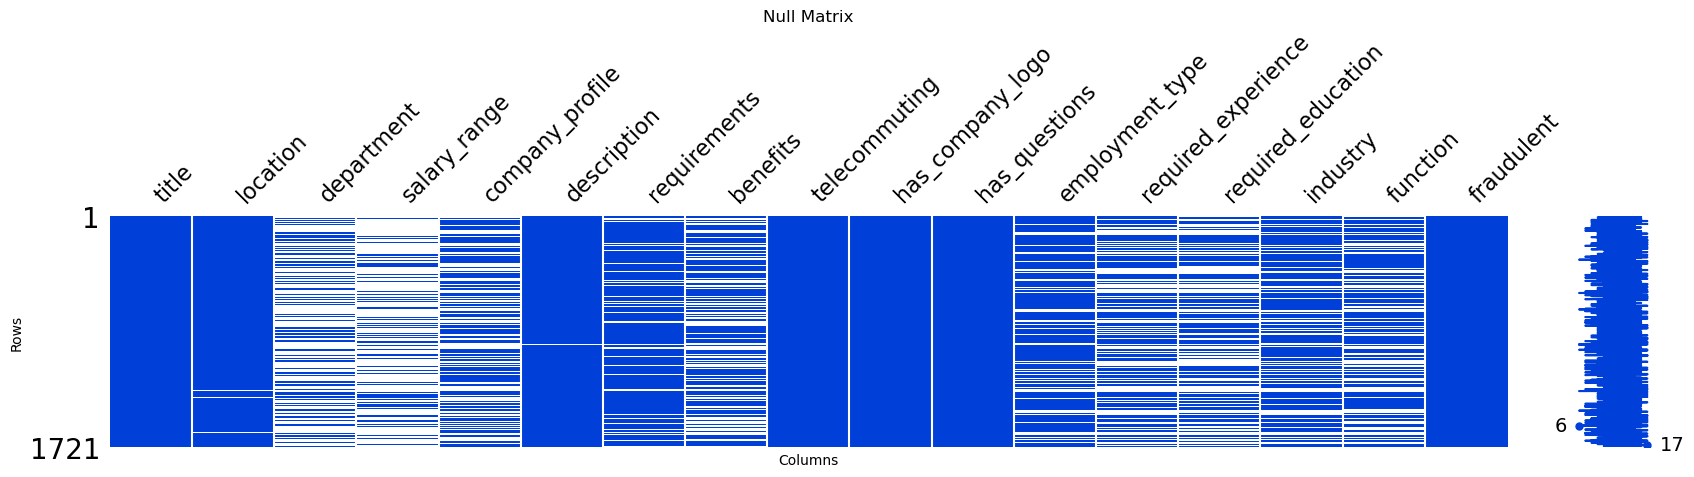

In [14]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(df, figsize=(20, 3), color=(0, 0.25, 0.85))

# Set plot labels and title
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.title("Null Matrix")

# Show the plot
plt.show()

Generally when the percentage of missing value in some column is more than 50% it it recommended to drop that column, but let's use another way. Instead of dropping the salary range and ignoring it completely let us create a new binary feature which will have 0 and 1 value representing that whether salary range is given or not.

### Data cleaning and Processing

- Dealing with missing values
- Dealing with outliers
- Encoding categorical values
- Cretion of embeddings

In [15]:
print(
    "Fraud JD having no department mentioned : "
    + str(df[df["fraudulent"] == 1]["department"].isnull().sum())
)

Fraud JD having no department mentioned : 524


In [16]:
# Let's create a copy of the dataframe and on that copy we will explore various processing techniques
temp_df = df.copy()

In [17]:
salary_range_present = []

for i in range(len(temp_df["salary_range"])):
    if pd.isna(temp_df["salary_range"].iloc[i]):
        salary_range_present.append(0)  # Salary range not provided
    else:
        salary_range_present.append(1)  # Salary range provided

temp_df["Salary_range_provided"] = salary_range_present
temp_df.drop(["salary_range"], inplace=True, axis=1)

Just like for salary_range feature we will do the same thing for the department feature.

In [18]:
department_mentioned = []
for i in range(len(temp_df["department"])):
    if pd.isna(temp_df["department"].iloc[i]):
        department_mentioned.append(0)  # Department not provided
    else:
        department_mentioned.append(1)  # Department mentioned

temp_df["department_mentioned"] = department_mentioned
temp_df.drop(["department"], inplace=True, axis=1)

In [19]:
# Let's impute the missing values in the location feature using the mode imputation
temp_df["location"] = temp_df["location"].fillna(temp_df["location"].mode()[0])
temp_df = temp_df.dropna(subset=["description"])

In [20]:
temp_df.drop(["function", "title", "company_profile", "location"], axis=1, inplace=True)

In [21]:
# Let's find out which employment type have most number of fake job postings
fakeJP_emptype = temp_df[temp_df["fraudulent"] == 1].groupby("employment_type").size()
fakeJP_emptype = np.round((fakeJP_emptype / fakeJP_emptype.sum()) * 100, 2)
fakeJP_emptype.sort_values(ascending=True)

employment_type
Temporary     0.32
Other         2.42
Contract      6.94
Part-time    11.77
Full-time    78.55
dtype: float64

In [22]:
# Let's find out which out of all fake job postings what is most common required experience
fakeJP_exp = temp_df[temp_df["fraudulent"] == 1].groupby("required_experience").size()
fakeJP_exp = np.round((fakeJP_exp / fakeJP_exp.sum()) * 100, 2)
fakeJP_exp.sort_values(ascending=True)

required_experience
Executive            2.33
Internship           2.33
Director             3.96
Associate            9.79
Not Applicable      13.99
Mid-Senior level    26.34
Entry level         41.26
dtype: float64

In [23]:
# Let's find out which out of all fake job postings what is most common required experience
fakeJP_edu = temp_df[temp_df["fraudulent"] == 1].groupby("required_education").size()
fakeJP_edu = np.round((fakeJP_edu / fakeJP_edu.sum()) * 100, 2)
fakeJP_edu.sort_values(ascending=True)

required_education
Doctorate                             0.24
Some College Coursework Completed     0.73
Professional                          0.97
Associate Degree                      1.46
Certification                         4.61
Some High School Coursework           4.85
Master's Degree                       7.52
Unspecified                          14.81
Bachelor's Degree                    24.03
High School or equivalent            40.78
dtype: float64

In [24]:
# Which industry have most number of fake job postings ( visualization oh skin tone color wali )
fakeJP_inds = temp_df[temp_df["fraudulent"] == 1].groupby("industry").size()
fakeJP_inds = np.round((fakeJP_inds / fakeJP_inds.sum()) * 100, 2)
fakeJP_inds.sort_values(ascending=False)

industry
Oil & Energy                   18.43
Accounting                      9.73
Hospital & Health Care          8.36
Marketing and Advertising       7.68
Financial Services              5.97
                               ...  
Online Media                    0.17
Security and Investigations     0.17
Utilities                       0.17
Warehousing                     0.17
Wholesale                       0.17
Length: 62, dtype: float64

In [25]:
# Dropping the featuers into the original dataframe
df.drop(["function", "title", "company_profile", "location"], axis=1, inplace=True)

In [26]:
salary_range_present = []

for i in range(len(df["salary_range"])):
    if pd.isna(df["salary_range"].iloc[i]):
        salary_range_present.append(0)  # Salary range not provided
    else:
        salary_range_present.append(1)  # Salary range provided

df["Salary_range_provided"] = salary_range_present
df.drop(["salary_range"], inplace=True, axis=1)

In [27]:
department_mentioned = []

for i in range(len(df["department"])):
    if pd.isna(df["department"].iloc[i]):
        department_mentioned.append(0)  # Department not provided
    else:
        department_mentioned.append(1)  # Department mentioned

df["department_mentioned"] = department_mentioned
df.drop(["department"], inplace=True, axis=1)

In [28]:
# Creating seperate dataframe for the textual features and other features
df = df.drop(["description", "requirements", "benefits"], axis=1)

df.to_csv('../Dataset/Fake_job_Non_Text.csv')

In [29]:
# Loading the dataset
df = pd.read_csv('../Dataset/Fake_job_Non_Text.csv')

# Data Processing and Model training (FEATURE TYPE 1)

In [30]:
df.sample(20)

,Unnamed: 0,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,fraudulent,Salary_range_provided,department_mentioned
659,659,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,1,0,1
1392,1399,1,0,1,NaN,NaN,NaN,NaN,1,0,1
1,1,0,0,1,Contract,Mid-Senior level,Bachelor's Degree,Information Technology and Services,1,1,0
368,368,0,0,0,Full-time,Associate,High School or equivalent,Marketing and Advertising,1,1,1
1720,1731,0,0,0,Full-time,NaN,NaN,Accounting,0,0,0
888,890,0,1,1,NaN,NaN,NaN,NaN,0,0,0
1044,1046,0,0,1,NaN,NaN,NaN,"Leisure, Travel & Tourism",1,0,0
1032,1034,0,1,1,Full-time,Not Applicable,Bachelor's Degree,Defense & Space,0,1,1
347,347,0,1,0,Full-time,Entry level,Master's Degree,Oil & Energy,1,0,0
1193,1196,0,0,0,Part-time,NaN,NaN,Banking,1,1,0


In [31]:
df.isnull().mean()*100

Unnamed: 0                0.000000
telecommuting             0.000000
has_company_logo          0.000000
has_questions             0.000000
employment_type          22.777455
required_experience      44.799535
required_education       48.111563
industry                 29.866357
fraudulent                0.000000
Salary_range_provided     0.000000
department_mentioned      0.000000
dtype: float64

In [35]:
# Performing train-test split
train_df, test_df = train_test_split(df, train_size=0.8, stratify=df['fraudulent'], shuffle=True)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (1376, 11)
Test data shape: (345, 11)


Blog Post referred for using miceforest : https://www.machinelearningplus.com/machine-learning/mice-imputation/

In [36]:
# Instantiating Ordinal encoder class
oe_exp = OrdinalEncoder(
    categories=[
        [
            "Not Applicable",
            "Internship",
            "Entry level",
            "Mid-Senior level",
            "Associate",
            "Director",
            "Executive",
        ]
    ],
    handle_unknown="use_encoded_value",
    unknown_value=np.nan,
)

oe_emptype = OrdinalEncoder(
    categories=[["Other", "Temporary", "Part-time", "Contract", "Full-time"]],
    handle_unknown="use_encoded_value",
    unknown_value=np.nan,
)

oe_edu = OrdinalEncoder(
    categories=[
        [
            "Unspecified",
            "Some High School Coursework",
            "High School or equivalent",
            "Some College Coursework Completed",
            "Vocational",
            "Vocational - HS Diploma",
            "Vocational - Degree",
            "Associate Degree",
            "Certification",
            "Professional",
            "Bachelor's Degree",
            "Master's Degree",
            "Doctorate",
        ]
    ],
    handle_unknown="use_encoded_value",
    unknown_value=np.nan,
)

# Instantiating the target encoder class
te_industry = ce.TargetEncoder(
    smoothing=0.2, handle_missing="return_nan", return_df=False
)

In [37]:
# Function for encoding
def encode_features(df, is_train=True, oe_exp=None, oe_edu=None, oe_emptype=None, te_industry=None, encoders=None):
   
    if is_train:
        
        # Fit and transform the training data
        df["required_experience"] = pd.Series(
            oe_exp.fit_transform(df["required_experience"].values.reshape(-1, 1)).reshape(-1)
        )
        df["required_education"] = pd.Series(
            oe_edu.fit_transform(df["required_education"].values.reshape(-1, 1)).reshape(-1)
        )
        df["employment_type"] = pd.Series(
            oe_emptype.fit_transform(df["employment_type"].values.reshape(-1, 1)).reshape(-1)
        )
        
        y = df["fraudulent"].values.reshape(-1, 1)
        df["industry"] = pd.Series(
            te_industry.fit_transform(df["industry"].values.reshape(-1, 1), y).reshape(-1)
        )
        
        # Return the transformed DataFrame and the fitted encoders
        encoders = {
            'oe_exp': oe_exp,
            'oe_edu': oe_edu,
            'oe_emptype': oe_emptype,
            'te_industry': te_industry
        }
        return df, encoders

    else:
        
        # Transform the test data using the provided encoders
        df["required_experience"] = pd.Series(
            encoders['oe_exp'].transform(df["required_experience"].values.reshape(-1, 1)).reshape(-1)
        )
        df["required_education"] = pd.Series(
            encoders['oe_edu'].transform(df["required_education"].values.reshape(-1, 1)).reshape(-1)
        )
        df["employment_type"] = pd.Series(
            encoders['oe_emptype'].transform(df["employment_type"].values.reshape(-1, 1)).reshape(-1)
        )
        
        df["industry"] = pd.Series(
            encoders['te_industry'].transform(df["industry"].values.reshape(-1, 1), df['fraudulent']).reshape(-1)
        )
        
        return df

In [38]:
# Calling the functions
train_df_encoded, fitted_encoders = encode_features(train_df, is_train=True, oe_exp=oe_exp, 
                                                    oe_edu=oe_edu, oe_emptype=oe_emptype, te_industry=te_industry)

test_df_encoded = encode_features(test_df, is_train=False, encoders=fitted_encoders)

In [39]:
train_df_encoded.drop(['Unnamed: 0'],axis=1,inplace=True)
test_df_encoded.drop(['Unnamed: 0'],axis=1,inplace=True)

In [56]:
import miceforest as mf
# Ensure the dataframe has a RangeIndex
# Ensure both train and test dataframes have RangeIndex
train_df_encoded.reset_index(drop=True, inplace=True)
test_df_encoded.reset_index(drop=True, inplace=True)

# Creating a kernel. 
kds = mf.ImputationKernel(
  train_df_encoded,
  
  random_state=100
)

# Run the MICE algorithm for 10 iterations
kds.mice(10)

# # Return the completed dataset.
# train_df_imputed = kds.complete_data()
# test_df_imputed = kds.impute_new_data(new_data=test_df_encoded).complete_data()

In [57]:

# Return the completed dataset.
train_df_imputed = kds.complete_data()
test_df_imputed = kds.impute_new_data(new_data=test_df_encoded).complete_data()

In [61]:
Imputed_df = pd.concat([train_df_imputed,test_df_imputed],axis=0)
Imputed_df.to_csv('../Dataset/Fake_job_Non_Text.csv',index=False)

## Scaling the values

In [62]:
# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(
    transformers=[("MinMaxScaling", MinMaxScaler(copy=False), [5, 6, 7, 8])],
    remainder="passthrough",
)

# Stacking column transformers to create a Processing pipeline
Processing_pipeline = Pipeline(steps=[("Scaling", scaling_transformer)], memory="Temp")

In [63]:
# Seperating the input and output training and testing data
X_train = train_df_imputed.drop(['fraudulent'],axis=1)
y_train = train_df_imputed['fraudulent']

X_test = test_df_imputed.drop(['fraudulent'],axis=1)
y_test = test_df_imputed['fraudulent']

In [64]:
Imputed_df.head(20)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,fraudulent,Salary_range_provided,department_mentioned
0,0,0,0,4.0,5.0,10.0,0.000000,1,1,0
1,0,1,1,2.0,0.0,2.0,0.254717,0,1,1
2,1,1,0,4.0,2.0,10.0,0.953488,1,0,0
3,0,1,1,4.0,3.0,2.0,0.000000,0,0,0
4,0,0,0,4.0,2.0,2.0,0.497093,1,0,0
5,0,1,0,4.0,3.0,10.0,0.497093,0,0,0
6,0,1,0,3.0,2.0,9.0,0.800000,0,0,0
7,0,1,0,3.0,3.0,10.0,0.254717,0,0,1
8,0,0,0,4.0,3.0,10.0,0.953488,1,0,0
9,0,1,0,4.0,3.0,10.0,0.571429,1,1,1


In [65]:
# Transforming the values 
X_train_temp = Processing_pipeline.fit_transform(X_train)

### Method 1: Correlation analysis

In [66]:
Temp_df = pd.concat([X_train, y_train], axis=1)
Corr_df = (
    Temp_df.corr()["fraudulent"]
    .to_frame()
    .reset_index()
    .rename(columns={"index": "Features", "fraudulent": "Correlation_Coefficient"})
)
Corr_df

,Features,Correlation_Coefficient
0,telecommuting,0.089998
1,has_company_logo,-0.506723
2,has_questions,-0.263478
3,employment_type,0.042530
4,required_experience,0.016655
5,required_education,-0.020419
6,industry,0.017292
7,Salary_range_provided,0.123314
8,department_mentioned,0.061847
9,fraudulent,1.000000


### Method 2: Random Forest Feature Importance

In [67]:
Rf_Model = RandomForestClassifier(n_estimators=100, random_state=42)
Rf_Model.fit(X_train_temp, y_train)

RandomForestClassifier(random_state=42)

In [68]:
Rf_Model_FI_df = pd.DataFrame(
    {"Features": X_train.columns, "RF_Importance": Rf_Model.feature_importances_}
)
Rf_Model_FI_df.sort_values(by="RF_Importance", inplace=True, ascending=False)
Rf_Model_FI_df

,Features,RF_Importance
5,required_education,0.267594
1,has_company_logo,0.217663
0,telecommuting,0.134334
8,department_mentioned,0.130395
3,employment_type,0.066242
6,industry,0.065899
7,Salary_range_provided,0.059669
2,has_questions,0.035469
4,required_experience,0.022734


### Method 3 : Gradient Boosting Feature importances

In [69]:
Gb_Model = GradientBoostingClassifier()
Gb_Model.fit(X_train_temp, y_train)

Gb_Model_FI_df = pd.DataFrame(
    {"Features": X_train.columns, "GB_Importance": Gb_Model.feature_importances_}
)
Gb_Model_FI_df.sort_values(by="GB_Importance", inplace=True, ascending=False)
Gb_Model_FI_df

,Features,GB_Importance
5,required_education,0.608042
3,employment_type,0.089597
1,has_company_logo,0.081100
6,industry,0.050670
0,telecommuting,0.044051
2,has_questions,0.043539
7,Salary_range_provided,0.035848
8,department_mentioned,0.032889
4,required_experience,0.014265


### Method 4 - Permutation Importance

In [70]:
# Processing the test data
X_test = Processing_pipeline.transform(X_test)

In [71]:
# Calculate Permutation Importance
Perm_importance = permutation_importance(
    Rf_Model, X_test, y_test, n_repeats=30, random_state=42
)

Perm_importance_df = pd.DataFrame(
    {"Features": X_train.columns, "Perm_importance": Perm_importance.importances_mean}
)
Perm_importance_df.sort_values(by="Perm_importance", inplace=True, ascending=False)
Perm_importance_df

,Features,Perm_importance
5,required_education,0.138357
6,industry,0.023092
2,has_questions,0.013816
4,required_experience,0.011208
8,department_mentioned,0.010725
0,telecommuting,0.010338
3,employment_type,0.008406
7,Salary_range_provided,0.008213
1,has_company_logo,-0.007923


### Method 6: Recrusive feature elimination

In [72]:
# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(Rf_Model, n_features_to_select=X_train.shape[1], step=1)
selector_label = selector_label.fit(X_train_temp, y_train)

# Get the selected features based on RFE
selected_features = X_train.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
RFE_df = pd.DataFrame(
    {"Features": selected_features, "RFE_importance": selected_coefficients}
)
RFE_df.sort_values(by="RFE_importance", inplace=True, ascending=False)
RFE_df

,Features,RFE_importance
5,required_education,0.267594
1,has_company_logo,0.217663
0,telecommuting,0.134334
8,department_mentioned,0.130395
3,employment_type,0.066242
6,industry,0.065899
7,Salary_range_provided,0.059669
2,has_questions,0.035469
4,required_experience,0.022734


In [73]:
# Merging the results of all the techniques into single data frame
FI_df = (
    Corr_df.merge(Rf_Model_FI_df, on="Features")
    .merge(Gb_Model_FI_df, on="Features")
    .merge(Perm_importance_df, on="Features")
    .merge(RFE_df, on="Features")
)

# Extracting only the technique values
FI_df_Results = FI_df[FI_df.columns[1:]]

# Let's normalize the values
FI_df_Results = FI_df_Results.divide(FI_df_Results.sum(axis=0), axis=1)
FI_df_Results.insert(0, "Features", FI_df["Features"])
FI_df_Results

,Features,Correlation_Coefficient,RF_Importance,GB_Importance,Perm_importance,RFE_importance
0,telecommuting,-0.205015,0.134334,0.044051,0.047811,0.134334
1,has_company_logo,1.154308,0.217663,0.081100,-0.036640,0.217663
2,has_questions,0.600198,0.035469,0.043539,0.063896,0.035469
3,employment_type,-0.096882,0.066242,0.089597,0.038874,0.066242
4,required_experience,-0.037940,0.022734,0.014265,0.051832,0.022734
5,required_education,0.046514,0.267594,0.608042,0.639857,0.267594
6,industry,-0.039390,0.065899,0.050670,0.106792,0.065899
7,Salary_range_provided,-0.280908,0.059669,0.035848,0.037980,0.059669
8,department_mentioned,-0.140887,0.130395,0.032889,0.049598,0.130395


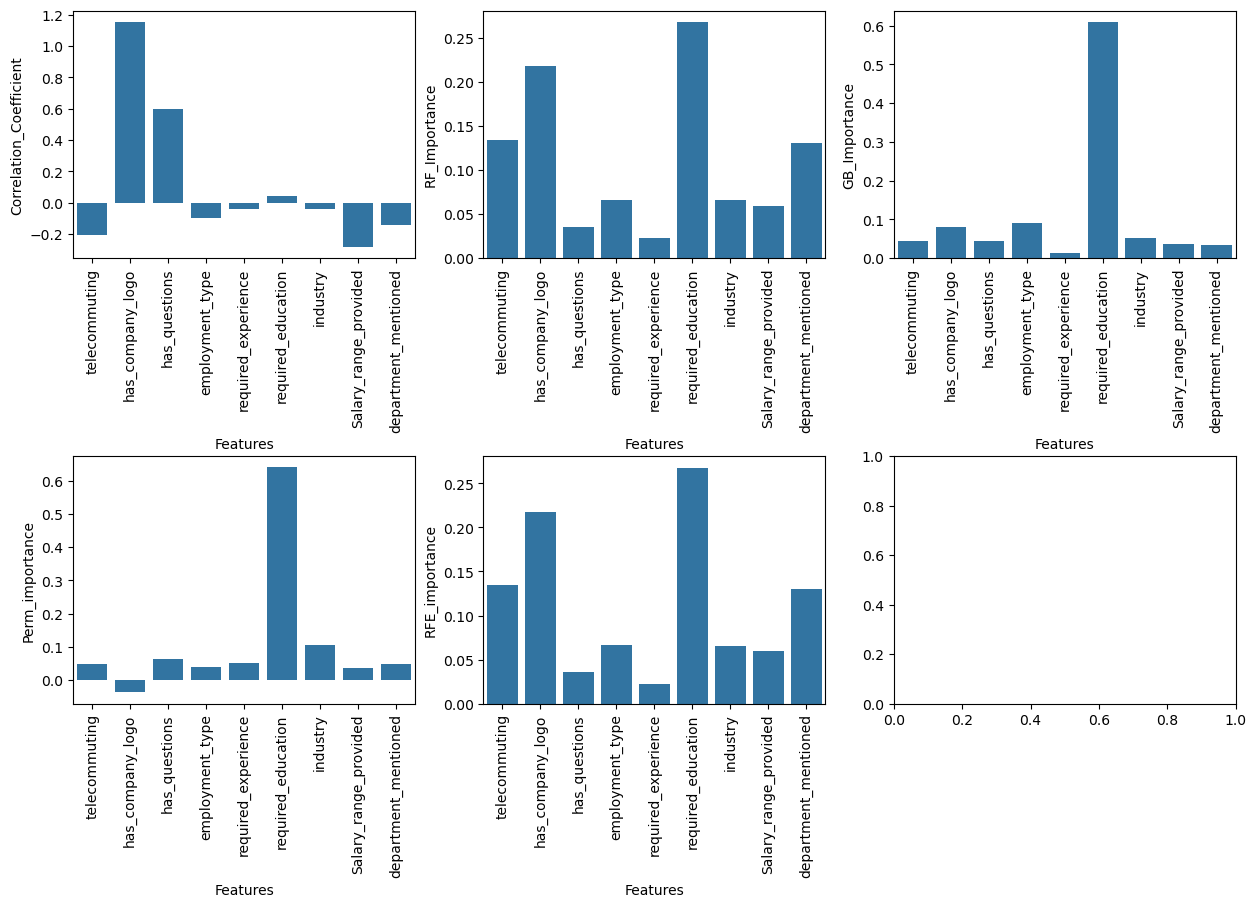

In [74]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

sns.barplot(
    x=FI_df_Results["Features"], y=FI_df_Results["Correlation_Coefficient"], ax=ax[0][0]
)
ax[0][0].set_xticks(range(len(FI_df_Results["Features"])))
ax[0][0].set_xticklabels(FI_df_Results["Features"], rotation=90)

sns.barplot(x=FI_df_Results["Features"], y=FI_df_Results["RF_Importance"], ax=ax[0][1])
ax[0][1].set_xticks(range(len(FI_df_Results["Features"])))
ax[0][1].set_xticklabels(FI_df_Results["Features"], rotation=90)

sns.barplot(x=FI_df_Results["Features"], y=FI_df_Results["GB_Importance"], ax=ax[0][2])
ax[0][2].set_xticks(range(len(FI_df_Results["Features"])))
ax[0][2].set_xticklabels(FI_df_Results["Features"], rotation=90)

sns.barplot(
    x=FI_df_Results["Features"], y=FI_df_Results["Perm_importance"], ax=ax[1][0]
)
ax[1][0].set_xticks(range(len(FI_df_Results["Features"])))
ax[1][0].set_xticklabels(FI_df_Results["Features"], rotation=90)

sns.barplot(x=FI_df_Results["Features"], y=FI_df_Results["RFE_importance"], ax=ax[1][1])
ax[1][1].set_xticks(range(len(FI_df_Results["Features"])))
ax[1][1].set_xticklabels(FI_df_Results["Features"], rotation=90)

plt.subplots_adjust(hspace=0.8)
plt.show()

In [75]:
def back_encoding(df):

    cols = ['has_company_logo', 'Salary_range_provided', 'department_mentioned']
    for col in cols:
        df[col] = df[col].replace({1: 'Yes', 0: 'No'})

    # Only considering the floor value
    cols = ['employment_type', 'required_experience', 'required_education']
    for col in cols:
        df[col] = np.floor(df[col])

    df['required_experience'] = df['required_experience'].replace({
        0: "Not Applicable",
        1: "Internship",
        2: "Entry level",
        3: "Mid-Senior level",
        4: "Associate",
        5: "Director",
        6: "Executive"})

    df['employment_type'] = df['employment_type'].replace(
        {0: "Other", 1: "Temporary", 2: "Part-time", 3: "Contract", 4: "Full-time"})

    df['required_education'] = df['required_education'].replace({
        0: "Unspecified",
        1: "Some High School Coursework",
        2: "High School or equivalent",
        3: "Some College Coursework Completed",
        4: "Vocational",
        5: "Vocational - HS Diploma",
        6: "Vocational - Degree",
        7: "Associate Degree",
        8: "Certification",
        9: "Professional",
        10: "Bachelor's Degree",
        11: "Master's Degree",
        12: "Doctorate"})
    return df

# Model selection

In [76]:
def scorer(model_name, model):
    """
    This function will take a model name as input and inject that model into the training pipeline to process
    and train the model using the training data. After that, this function will use K-fold cross-validation technique
    to calculate the average classification metrics and make predictions on the test data to calculate the F1-score.
    """

    output = []
    output.append(model_name)

    # Stacking column transformers to create a Training pipeline
    Training_pipeline = Pipeline(
        steps=[("classifier", model)]
    )

    # Define scoring functions with zero_division=1
    scorer_precision = make_scorer(precision_score, zero_division=1)
    scorer_recall = make_scorer(recall_score, zero_division=1)
    scorer_f1 = make_scorer(f1_score, zero_division=1)

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(
        Training_pipeline, X_train_temp, y_train, cv=kfold, scoring="accuracy"
    )
    precision_scores = cross_val_score(
        Training_pipeline, X_train_temp, y_train, cv=kfold, scoring=scorer_precision
    )
    recall_scores = cross_val_score(
        Training_pipeline, X_train_temp, y_train, cv=kfold, scoring=scorer_recall
    )
    f1_scores = cross_val_score(
        Training_pipeline, X_train_temp, y_train, cv=kfold, scoring=scorer_f1
    )

    output.append(accuracy_scores.mean())
    output.append(precision_scores.mean())
    output.append(recall_scores.mean())
    output.append(f1_scores.mean())

    return output

### Model selection

In [77]:
classification_model_dict = {
    "logistic_regression": LogisticRegression(),
    "svm": SVC(),
    "knn": KNeighborsClassifier(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
    "gradient_boosting": GradientBoostingClassifier(),
    "adaboost": AdaBoostClassifier(),
    "gaussian_nb": GaussianNB(),
    "xgboost": XGBClassifier(),
}

In [78]:
%%time
model_output = []
for model_name, model in classification_model_dict.items():
    model_output.append(scorer(model_name, model))

CPU times: user 25 s, sys: 4.67 s, total: 29.7 s
Wall time: 10.1 s


In [79]:
model_df = pd.DataFrame(
    model_output, columns=["name", "accuracy", "precision", "recall", "f1_score"]
)
model_df.sort_values(["accuracy"])

,name,accuracy,precision,recall,f1_score
3,decision_tree,0.703523,0.717077,0.671452,0.691647
2,knn,0.738363,0.740739,0.728952,0.734107
7,gaussian_nb,0.738374,0.754121,0.700963,0.725278
4,random_forest,0.739104,0.740591,0.748404,0.734519
8,xgboost,0.739776,0.741199,0.736130,0.736753
6,adaboost,0.741966,0.749313,0.721909,0.734321
0,logistic_regression,0.748514,0.770210,0.703325,0.734142
1,svm,0.750714,0.793430,0.673483,0.727032
5,gradient_boosting,0.763789,0.772109,0.746395,0.757398


In [80]:
# List to store the F1 scores
f1_scores = []

In [81]:
# Define the domain space for GradientBoostingClassifier
space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 1),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "min_samples_split": hp.uniform("min_samples_split", 0.1, 1),
    "min_samples_leaf": hp.uniform("min_samples_leaf", 0.1, 0.5),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "random_state": 0,
}

def objective(space):
    model = GradientBoostingClassifier(
        n_estimators=int(space["n_estimators"]),
        learning_rate=space["learning_rate"],
        max_depth=int(space["max_depth"]),
        min_samples_split=int(space["min_samples_split"] * X_train_temp.shape[0]),
        min_samples_leaf=int(space["min_samples_leaf"] * X_train_temp.shape[0]),
        subsample=space["subsample"],
        random_state=int(space["random_state"]),
    )

    # Training the model
    model.fit(X_train_temp, y_train)

    # Getting predictions from the trained model and computing F1-score
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    print("F1-score:", f1)
    return {"loss": -f1, "status": STATUS_OK}

# Optimization
trials = Trials()
best_parms = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150,
            trials=trials)

F1-score:                                                                       
0.7068965517241379                                                              
F1-score:                                                                       
0.0                                                                             
F1-score:                                                                       
0.6964285714285714                                                              
F1-score:                                                                       
0.7052023121387283                                                              
F1-score:                                                                       
0.6964285714285714                                                              
F1-score:                                                                       
0.0                                                                             
F1-score:                   

In [82]:
print("Best hyperparameters:", best_parms)

Best hyperparameters: {'learning_rate': 0.1836436715064838, 'max_depth': 14.0, 'min_samples_leaf': 0.15554763609664904, 'min_samples_split': 0.47593509168441384, 'n_estimators': 210.0, 'subsample': 0.7547821658234942}


## Final model training

In [83]:
# Best hyperparameters obtained from hyperparameter tuning
best = {
    'learning_rate': 0.24576725884267056,
    'max_depth': 13.0,
    'min_samples_leaf': 0.12127867177347917,
    'min_samples_split': 0.3400670761876182,
    'n_estimators': 233.0,
    'subsample': 0.9807114088853718
}

# Convert min_samples_split and min_samples_leaf to absolute numbers
min_samples_split = int(best['min_samples_split'] * X_train_temp.shape[0])
min_samples_leaf = int(best['min_samples_leaf'] * X_train_temp.shape[0])

# Create the GradientBoostingClassifier with the best hyperparameters
classifier = GradientBoostingClassifier(
    n_estimators=int(best["n_estimators"]),
    learning_rate=best["learning_rate"],
    max_depth=int(best["max_depth"]),
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    subsample=best["subsample"],
    random_state=0
)

# Training the model
classifier.fit(X_train_temp, y_train)

GradientBoostingClassifier(learning_rate=0.24576725884267056, max_depth=13,
                           min_samples_leaf=166, min_samples_split=467,
                           n_estimators=233, random_state=0,
                           subsample=0.9807114088853718)

## Validating model performance

In [84]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(classifier, X_train_temp, y_train, cv=kfold, scoring="accuracy")
print("Average Accuracy SCORE : ", scores.mean())

Average Accuracy SCORE :  0.7536178990796571


In [85]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(classifier, X_train_temp, y_train, cv=kfold, scoring="precision")
print("Average precision SCORE : ", scores.mean())

Average precision SCORE :  0.7533641799563351


In [86]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(classifier, X_train_temp, y_train, cv=kfold, scoring="recall")
print("Average recall SCORE : ", scores.mean())

Average recall SCORE :  0.7498457288907284


In [87]:
# Getting predictions from the model
y_pred = classifier.predict(X_test)

In [88]:
# Display the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       173
           1       0.71      0.72      0.71       172

    accuracy                           0.71       345
   macro avg       0.71      0.71      0.71       345
weighted avg       0.71      0.71      0.71       345



# Saving the model
Differences between pickle and joblib:
- Efficiency: joblib is more efficient for large numpy arrays, as it uses memory mapping techniques that are faster and more memory-efficient.
- Compression: joblib supports compression, which can reduce the file size.
- Usage: pickle is a more general-purpose serialization library, while joblib is specifically designed for the types of objects commonly encountered in machine learning.

In [90]:
# Specifying the file path where you want to save the model
model_path = "../artifacts/GB_classifier_model.pkl"

# Save the trained model to a file
joblib.dump(classifier, model_path)

['../artifacts/GB_classifier_model.pkl']

In [ ]:
# Save the processing pipeline to a file
with open("../Artifacts/Processing_pipeline.pkl", "wb") as f:
    pickle.dump(Processing_pipeline, f)

In [ ]:
# Save the encoding objects
with open("../Artifacts/oe_exp.pkl", "wb") as f:
    pickle.dump(oe_exp, f)

with open("../Artifacts/oe_emptype.pkl", "wb") as f:
    pickle.dump(oe_emptype, f)

with open("../Artifacts/oe_edu.pkl", "wb") as f:
    pickle.dump(oe_edu, f)

with open("../Artifacts/te_industry.pkl", "wb") as f:
    pickle.dump(te_industry, f)